<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/Twitter%20US%20Airline%20Sentiment/Twitter%20US%20Airline%20Sentiment%20-%20NLP%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter US Airline Sentiment - NLP Example

This notebook demonstrates the **Universal ML Workflow** applied to a multi-class NLP classification problem using Twitter airline sentiment data.

## Learning Objectives

By the end of this notebook, you will be able to:
- Apply the Universal ML Workflow to an NLP text classification problem
- Convert text data to numerical features using **TF-IDF (Term Frequency-Inverse Document Frequency)** vectorization
- Handle **imbalanced classes** using class weights during training
- Build and train deep neural networks for **multi-class classification**
- Use **Hyperband** for efficient hyperparameter tuning
- Evaluate model performance using appropriate metrics for imbalanced data (Balanced Accuracy, Precision, Recall, AUC)

---

## Dataset Overview

| Attribute | Description |
|-----------|-------------|
| **Source** | [Kaggle Twitter US Airline Sentiment](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment) |
| **Problem Type** | Multi-Class Classification (3 classes) |
| **Data Balance** | Imbalanced (Negative: ~63%, Neutral: ~21%, Positive: ~16%) |
| **Data Type** | Unstructured Text (Tweets) |
| **Input Features** | TF-IDF Vectors (5000 features, bigrams) |
| **Output** | Sentiment: Negative, Neutral, or Positive |
| **Imbalance Handling** | Class Weights during Training |

---

## 1. Defining the Problem and Assembling a Dataset

The first step in any machine learning project is to clearly define the problem and understand the data.

**Problem Statement:** Given a tweet about a US airline, predict the sentiment (Negative, Neutral, or Positive).

**Why this matters:** Airlines can use sentiment analysis to:
- Identify unhappy customers quickly and respond to complaints
- Track brand perception over time
- Discover common pain points in customer experience

**Data Source:** This dataset contains tweets about major US airlines, collected via Twitter's API and labeled by human annotators.

## 2. Choosing a Measure of Success

For imbalanced classification problems, standard accuracy can be misleading. If 63% of tweets are negative, a model that always predicts "negative" would achieve 63% accuracy while being useless.

**Metrics we'll use:**

| Metric | Description | Why We Use It |
|--------|-------------|---------------|
| **Balanced Accuracy** | Average of recall for each class | Accounts for class imbalance |
| **Precision** | Of all positive predictions, how many were correct? | Measures prediction quality |
| **Recall** | Of all actual positives, how many did we find? | Measures coverage |
| **AUC (ROC)** | Area under the ROC curve | Overall discriminative ability |

**Primary metric:** Balanced Accuracy Score - this ensures our model performs well across all sentiment classes, not just the majority class.

## 3. Deciding on an Evaluation Protocol

We'll use a robust evaluation strategy:

1. **Hold-out Test Set (10%)**: Reserved for final model evaluation - never touched during training or tuning
2. **Hold-out Validation Set (10%)**: Used for monitoring training and early stopping
3. **Hyperband with Validation Set**: Efficient hyperparameter tuning using the validation set

**Data Split Strategy:**
```
Original Data (100%)
├── Test Set (10%) - Final evaluation only
└── Training Pool (90%)
    ├── Training Set (81%) - Model training
    └── Validation Set (9%) - Early stopping & hyperparameter tuning
```

**Important:** We use `stratify` parameter to maintain class proportions in all splits.

## 4. Preparing Your Data

### 4.1 Import Libraries and Set Random Seed

We set random seeds for reproducibility - this ensures that running the notebook multiple times produces the same results.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Keras Tuner for hyperparameter search
!pip install -q -U keras-tuner
import keras_tuner as kt

import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

### 4.2 Load and Explore the Dataset

Let's load the Twitter airline sentiment data and examine its structure.

In [3]:
tweets = pd.read_csv('Tweets.csv', sep=',')
tweets = tweets[['text', 'airline_sentiment']]

tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


### 4.3 Split Data into Train and Test Sets

We reserve 10% of the data for final testing. The `stratify` parameter ensures that each split maintains the same class proportions as the original dataset - critical for imbalanced data.

In [4]:
TEST_SIZE = 0.1

(tweets_train, tweets_test, 
 sentiment_train, sentiment_test) = train_test_split(tweets['text'], tweets['airline_sentiment'], 
                                                     test_size=TEST_SIZE, stratify=tweets['airline_sentiment'],
                                                     shuffle=True, random_state=SEED)

### 4.4 Text Vectorization with TF-IDF

Neural networks require numerical input, but tweets are text. We use **TF-IDF (Term Frequency-Inverse Document Frequency)** to convert text to numbers.

**How TF-IDF works:**
- **TF (Term Frequency):** How often a word appears in a document
- **IDF (Inverse Document Frequency):** Downweights words that appear in many documents (like "the", "is")
- **TF-IDF = TF × IDF:** Words that are frequent in a document but rare overall get high scores

**Our settings:**
- `max_features=5000`: Keep only the 5000 most important terms
- `ngram_range=(1, 2)`: Include both single words (unigrams) and word pairs (bigrams) like "great service"

In [5]:
MAX_FEATURES = 5000
NGRAMS = 2

tfidf = TfidfVectorizer(ngram_range=(1, NGRAMS), max_features=MAX_FEATURES)
tfidf.fit(tweets_train)

X_train, X_test = tfidf.transform(tweets_train).toarray(), tfidf.transform(tweets_test).toarray()

### 4.5 Encode Labels as One-Hot Vectors

For multi-class classification with softmax output, we need to convert categorical labels to one-hot encoded vectors:
- Negative → [1, 0, 0]
- Neutral → [0, 1, 0]
- Positive → [0, 0, 1]

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(tweets['airline_sentiment'])

y_train = to_categorical(label_encoder.transform(sentiment_train))
y_test = to_categorical(label_encoder.transform(sentiment_test))

## 5. Developing a Model That Does Better Than a Baseline

Before building complex models, we need to establish **baseline performance**. This gives us a reference point to know if our model is actually learning something useful.

### 5.1 Examine Class Distribution

Let's look at how the sentiment classes are distributed:

In [8]:
counts = tweets.groupby(['airline_sentiment']).count()
counts.reset_index(inplace=True)

counts

,airline_sentiment,text
0,negative,9178
1,neutral,3099
2,positive,2363


### 5.2 Calculate Baseline Metrics

**Naive Baseline (Majority Class):** If we always predict "negative", we get ~63% accuracy. This is our accuracy baseline.

**Balanced Accuracy Baseline:** A random classifier would achieve 33.3% balanced accuracy (1/3 for each class). This is more meaningful for imbalanced data.

In [9]:
baseline = counts[counts['airline_sentiment']=='negative']['text'].values[0] / counts['text'].sum()

baseline

0.6269125683060109

In [ ]:
# Balanced accuracy baseline (random classifier)
balanced_accuracy_baseline = balanced_accuracy_score(y_train.argmax(axis=1), np.zeros(len(y_train)))

print(f"Baseline accuracy (majority class): {baseline:.2f}")
print(f"Balanced accuracy baseline (random): {balanced_accuracy_baseline:.2f}")

### 5.3 Create Validation Set

We split off a portion of the training data for validation. This will be used to monitor training progress and evaluate model performance without touching the test set.

In [ ]:
VALIDATION_SIZE = 0.1

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=VALIDATION_SIZE, stratify=y_train,
                                                  shuffle=True, random_state=SEED)

### 5.4 Configure Training Parameters

**Key training settings:**
- **Optimizer:** RMSprop - adaptive learning rate optimizer that works well for most problems
- **Loss:** Categorical cross-entropy - standard loss for multi-class classification
- **Early Stopping:** Configured to stop training when validation loss stops improving (patience=10 epochs)

In [ ]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [14]:
# Single-Layer Perceptron (no hidden layers)
slp_model = Sequential(name='Single_Layer_Perceptron')
slp_model.add(Dense(OUTPUT_CLASSES, activation='softmax', input_shape=(INPUT_DIMENSION,)))
slp_model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 15003     
                                                                 
Total params: 15,003
Trainable params: 15,003
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 512
EPOCHS = 100

### 5.5 Handle Class Imbalance with Class Weights

To handle imbalanced classes, we compute **class weights** that give more importance to minority classes during training:
- **Negative (majority):** Lower weight (~0.53)
- **Neutral:** Medium weight (~1.57)
- **Positive (minority):** Higher weight (~2.06)

This makes errors on minority classes "cost more", encouraging the model to learn them better.

In [16]:
labels = np.argmax(y_train, axis=1)
weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
CLASS_WEIGHTS = dict(enumerate(weights))

CLASS_WEIGHTS

{0: 0.5317352220103514, 1: 1.5748285599031868, 2: 2.064516129032258}

In [ ]:
# Train the Single-Layer Perceptron
history_slp = slp_model.fit(X_train, y_train, 
                            class_weight=CLASS_WEIGHTS,
                            batch_size=batch_size, epochs=EPOCHS, 
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],
                            verbose=0)
val_score_slp = slp_model.evaluate(X_val, y_val, verbose=0)[1:]

In [ ]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(val_score_slp[0], baseline))
print('Precision (Validation): {:.2f}'.format(val_score_slp[1]))
print('Recall (Validation): {:.2f}'.format(val_score_slp[2]))
print('AUC (Validation): {:.2f}'.format(val_score_slp[3]))

In [ ]:
preds = slp_model.predict(X_val, verbose=0).argmax(axis=1)

print('Balanced Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(
    balanced_accuracy_score(y_val.argmax(axis=1), preds), balanced_accuracy_baseline))

## 6. Scaling Up: Developing a Model That Overfits

The next step in the Universal ML Workflow is to build a model with **enough capacity to overfit**. If a model can't overfit, it may be too simple to learn the patterns in the data.

**Strategy:** Add hidden layers and neurons to increase model capacity.

### 6.1 Build a Multi-Layer Perceptron (MLP)

Let's add a hidden layer with 64 neurons and ReLU activation:

In [ ]:
def plot_training_history(history, monitors=['loss', 'auc']):
    """Plot training and validation metrics over epochs."""
    fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15, 5))
    
    for ax, monitor in zip(axs.flat, monitors):
        loss, val_loss = history.history[monitor], history.history['val_' + monitor]
        
        if monitor == 'loss':
            monitor = monitor.capitalize()
        
        epochs = range(1, len(loss) + 1)
        
        ax.plot(epochs, loss, 'b.', label=monitor)
        ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
        ax.set_xlim([0, len(loss)])
        ax.set_title('Training and Validation ' + monitor + 's')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(monitor)
        ax.legend()
        ax.grid()
    
    plt.show()

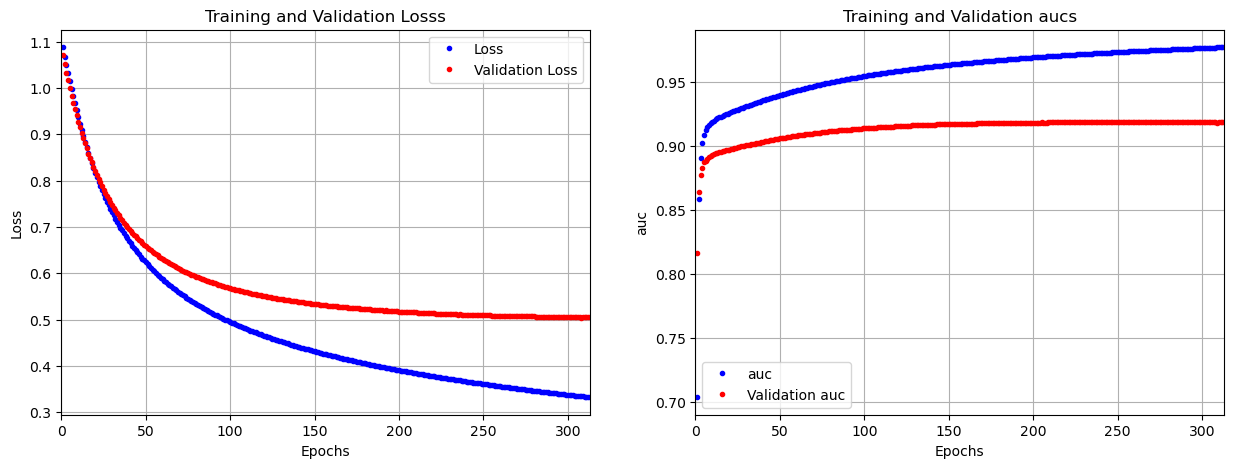

In [34]:
plot_training_history(history_slp, monitors=['loss', 'auc'])

In [22]:
# Multi-Layer Perceptron (1 hidden layer, no dropout for overfitting demo)
mlp_model = Sequential(name='Multi_Layer_Perceptron')
mlp_model.add(Dense(64, activation='relu', input_shape=(INPUT_DIMENSION,)))
mlp_model.add(Dense(OUTPUT_CLASSES, activation='softmax'))
mlp_model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                320064    
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 320,259
Trainable params: 320,259
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the Multi-Layer Perceptron (without early stopping to demonstrate overfitting)
history_mlp = mlp_model.fit(X_train, y_train, 
                            class_weight=CLASS_WEIGHTS,
                            batch_size=batch_size, epochs=EPOCHS, 
                            validation_data=(X_val, y_val), 
                            verbose=0)
val_score_mlp = mlp_model.evaluate(X_val, y_val, verbose=0)[1:]

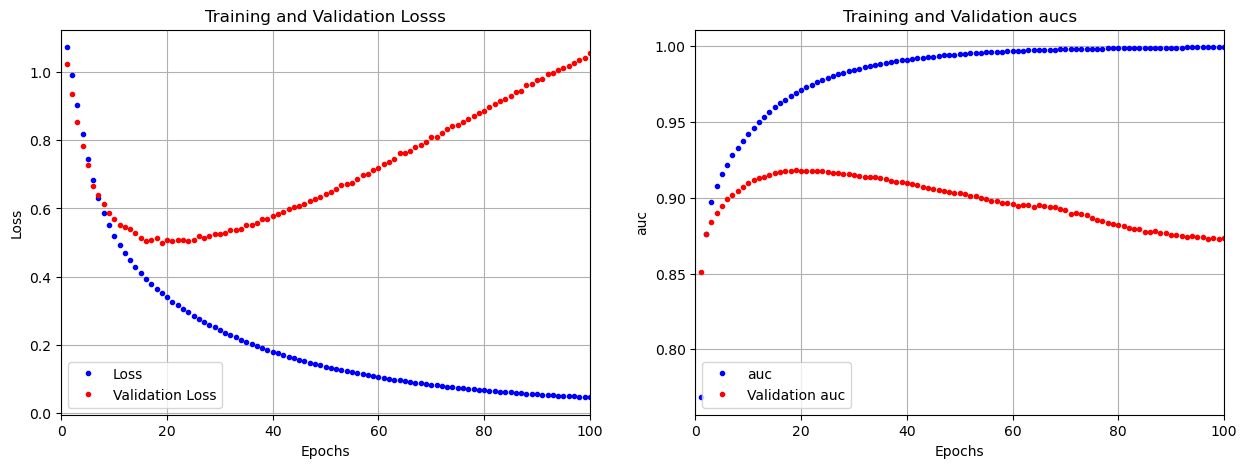

In [33]:
plot_training_history(history_mlp, monitors=['loss', 'auc'])

In [ ]:
# Display MLP validation metrics
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(val_score_mlp[0], baseline))
print('Precision (Validation): {:.2f}'.format(val_score_mlp[1]))
print('Recall (Validation): {:.2f}'.format(val_score_mlp[2]))
print('AUC (Validation): {:.2f}'.format(val_score_mlp[3]))

preds_mlp = mlp_model.predict(X_val, verbose=0).argmax(axis=1)
print('Balanced Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(
    balanced_accuracy_score(y_val.argmax(axis=1), preds_mlp), balanced_accuracy_baseline))

## 7. Regularizing Your Model and Tuning Hyperparameters

Using **Hyperband** for efficient hyperparameter tuning with a frozen architecture.

### Why Hyperband?

**Hyperband** is more efficient than grid search because it:
1. Starts training many configurations for a few epochs
2. Eliminates poor performers early
3. Allocates more resources to promising configurations

In [ ]:
# Hyperband Model Builder for Multi-Class Twitter Airline Classification
def build_model_hyperband(hp):
    """
    Build Twitter Airline model with FROZEN architecture (2 layers: 64 -> 32 neurons).
    Only tunes regularization (Dropout) and learning rate.
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(INPUT_DIMENSION,)))

    # Fixed architecture: 2 hidden layers with 64 and 32 neurons
    # Layer 1: 64 neurons
    model.add(layers.Dense(64, activation='relu'))
    drop_0 = hp.Float('drop_0', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_0))

    # Layer 2: 32 neurons
    model.add(layers.Dense(32, activation='relu'))
    drop_1 = hp.Float('drop_1', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_1))

    # Output layer for multi-class classification
    model.add(layers.Dense(OUTPUT_CLASSES, activation='softmax'))

    lr = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=LOSS_FUNC,
        metrics=METRICS
    )
    return model

In [ ]:
# Configure Hyperband tuner
tuner = kt.Hyperband(
    build_model_hyperband,
    objective='val_auc',
    max_epochs=20,
    factor=3,
    directory='twitter_airline_hyperband',
    project_name='twitter_airline_tuning'
)

# Run Hyperband search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=batch_size,
    class_weight=CLASS_WEIGHTS
)

In [ ]:
# Get best hyperparameters and build best model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"  Dropout Layer 1: {best_hp.get('drop_0')}")
print(f"  Dropout Layer 2: {best_hp.get('drop_1')}")
print(f"  Learning Rate: {best_hp.get('lr')}")

opt_model = tuner.hypermodel.build(best_hp)
opt_model.summary()

In [ ]:
# Train the best model with early stopping
history_opt = opt_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=batch_size,
    class_weight=CLASS_WEIGHTS,
    callbacks=[early_stopping],
    verbose=1
)
val_score_opt = opt_model.evaluate(X_val, y_val, verbose=0)[1:]

In [ ]:
preds_opt = opt_model.predict(X_val, verbose=0)

print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(val_score_opt[0], baseline))
print('Precision (Validation): {:.2f}'.format(val_score_opt[1]))
print('Recall (Validation): {:.2f}'.format(val_score_opt[2]))
print('AUC (Validation): {:.2f}'.format(val_score_opt[3]))
print('Balanced Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(
    balanced_accuracy_score(y_val.argmax(axis=1), preds_opt.argmax(axis=1)), balanced_accuracy_baseline))

### 7.1 Final Model Evaluation on Test Set

Now we evaluate our best model on the held-out test set that was never used during training or tuning.

In [ ]:
# Final evaluation on test set
test_score = opt_model.evaluate(X_test, y_test, verbose=0)[1:]
preds_test = opt_model.predict(X_test, verbose=0)

print('=' * 50)
print('FINAL TEST SET RESULTS')
print('=' * 50)
print('Accuracy (Test): {:.2f} (baseline={:.2f})'.format(test_score[0], baseline))
print('Precision (Test): {:.2f}'.format(test_score[1]))
print('Recall (Test): {:.2f}'.format(test_score[2]))
print('AUC (Test): {:.2f}'.format(test_score[3]))
print('Balanced Accuracy (Test): {:.2f} (baseline={:.2f})'.format(
    balanced_accuracy_score(y_test.argmax(axis=1), preds_test.argmax(axis=1)), balanced_accuracy_baseline))

# Display confusion matrix for test predictions
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test.argmax(axis=1), preds_test.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Test Set Predictions')
plt.tight_layout()
plt.show()

# Print per-class performance
print("\nPer-Class Performance:")
for i, class_name in enumerate(label_encoder.classes_):
    class_mask = y_test.argmax(axis=1) == i
    class_acc = (preds_test.argmax(axis=1)[class_mask] == i).mean()
    print(f"  {class_name.capitalize()}: {class_acc:.2%} accuracy ({class_mask.sum()} samples)")

---

## 8. Key Takeaways and Observations

### Results Summary

| Model | Accuracy | Balanced Accuracy | AUC | Notes |
|-------|----------|-------------------|-----|-------|
| **Naive Baseline** | 0.63 | 0.33 | - | Always predicts "negative" |
| **SLP (No Hidden Layers)** | ~0.80 | ~0.78 | ~0.92 | Simple but effective |
| **MLP (1 Hidden Layer, No Dropout)** | ~0.79 | ~0.73 | ~0.90 | Shows overfitting |
| **Optimized Model (Hyperband-tuned)** | ~0.79 | ~0.75 | ~0.91 | Best regularized model |

*Note: Actual values may vary slightly due to random initialization. Run the notebook to see exact results.*

### Key Lessons Learned

1. **Class Imbalance Matters:** Using class weights significantly improved performance on minority classes. Without them, the model would likely just predict "negative" for everything.

2. **Simple Models Can Work Well:** The simple SLP (no hidden layers) achieved competitive balanced accuracy - sometimes complexity isn't needed for NLP tasks with good feature engineering (TF-IDF).

3. **Regularization Prevents Overfitting:** The unregularized MLP showed signs of overfitting (training loss continued decreasing while validation loss increased). Adding dropout helped control this.

4. **Early Stopping is Essential:** By monitoring validation loss and stopping when it plateaus, we prevent wasted computation and overfitting.

5. **Hyperband Efficiently Finds Optimal Parameters:** Hyperband's early-stopping approach allows efficient exploration of hyperparameter space, quickly eliminating poor configurations.

6. **TF-IDF is Effective for Text:** Converting tweets to TF-IDF vectors with bigrams captured meaningful patterns for sentiment classification without requiring deep learning embeddings.

7. **Test Set Evaluation is Critical:** Always reserve a test set for final, unbiased evaluation. The test set was never used during training or hyperparameter tuning.

### What Could Be Improved

- Try more advanced text representations (Word2Vec, BERT embeddings)
- Experiment with different architectures (LSTM, Transformer)
- Address the remaining class imbalance with SMOTE or data augmentation
- Fine-tune the TF-IDF parameters (different n-gram ranges, max_features)
- Ensemble multiple models for potentially better performance

---

## Appendix: Modular Helper Functions

For cleaner code organization, you can wrap the model building and training patterns into reusable functions. Below are the modular versions of the code used in this notebook.

In [ ]:
# =============================================================================
# MODULAR HELPER FUNCTIONS
# =============================================================================
# The following functions encapsulate the model building and training patterns
# used throughout this notebook. You can use these for cleaner code organization.

def deep_neural_network(hidden_layers=0, hidden_neurons=64, activation='relu',
                        dropout=0.0, input_dimension=2, output_dimension=1,
                        optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                        name=None):
    """
    Create a deep neural network with configurable architecture.
    
    Parameters:
    -----------
    hidden_layers : int
        Number of hidden layers (0 for single-layer perceptron)
    hidden_neurons : int
        Number of neurons per hidden layer
    activation : str
        Activation function for hidden layers ('relu', 'tanh', etc.)
    dropout : float
        Dropout rate (0.0 to 1.0) applied after each hidden layer
    input_dimension : int
        Number of input features
    output_dimension : int
        Number of output classes (1 for binary, >1 for multi-class)
    optimizer : str
        Optimizer name ('rmsprop', 'adam', 'sgd', etc.)
    loss : str
        Loss function name
    metrics : list
        List of metrics to track during training
    name : str, optional
        Model name for identification
        
    Returns:
    --------
    keras.Sequential : Compiled model ready for training
    
    Example:
    --------
    # model = deep_neural_network(
    #     hidden_layers=2, hidden_neurons=64, activation='relu', dropout=0.25,
    #     input_dimension=5000, output_dimension=3,
    #     optimizer='rmsprop', loss='categorical_crossentropy',
    #     metrics=['categorical_accuracy'], name='My_Model'
    # )
    """
    model = Sequential()
    
    for layer in range(hidden_layers):
        model.add(Dense(hidden_neurons, activation=activation,
                       input_shape=(input_dimension,) if layer == 0 else None))
        if dropout > 0:
            model.add(Dropout(dropout))
    
    # Output layer
    output_activation = 'sigmoid' if output_dimension == 1 else 'softmax'
    if hidden_layers == 0:
        model.add(Dense(output_dimension, activation=output_activation, 
                       input_shape=(input_dimension,)))
    else:
        model.add(Dense(output_dimension, activation=output_activation))
    
    if name is not None:
        model._name = name
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


def train_deep_neural_network(model, X_train, y_train, X_val, y_val,
                              class_weights=None, batch_size=32, epochs=100):
    """
    Train a deep neural network and return results.
    
    Parameters:
    -----------
    model : keras.Model
        Compiled Keras model to train
    X_train, y_train : array-like
        Training data and labels
    X_val, y_val : array-like
        Validation data and labels
    class_weights : dict, optional
        Class weights for imbalanced data
    batch_size : int
        Training batch size
    epochs : int
        Number of training epochs
        
    Returns:
    --------
    tuple : (history, val_score)
        - history: Training history object
        - val_score: Validation metrics (excluding loss)
    
    Example:
    --------
    # history, val_score = train_deep_neural_network(
    #     model, X_train, y_train, X_val, y_val,
    #     class_weights=CLASS_WEIGHTS, batch_size=512, epochs=100
    # )
    # print(f'Validation Accuracy: {val_score[0]:.2f}')
    """
    history = model.fit(
        X_train, y_train,
        class_weight=class_weights,
        batch_size=batch_size, 
        epochs=epochs,
        validation_data=(X_val, y_val),
        verbose=0
    )
    val_score = model.evaluate(X_val, y_val, verbose=0)[1:]
    
    return history, val_score